#  PanSTARRS - WISE cross-match: Maximum Likelihood

In [1]:
import numpy as np
from astropy.table import Table, join
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
import pickle
from tqdm import tnrange, tqdm_notebook

In [2]:
from IPython.display import clear_output
from mltier1 import parallel_process, SingleMLEstimator

In [3]:
%load_ext autoreload

In [4]:
%autoreload

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Load the data

### Load the catalogues

In [6]:
panstarrs = Table.read("panstarrs_bootes_u2.fits")

In [7]:
wise = Table.read("wise_bootes_u2.fits")

In [8]:
len(panstarrs)

296993

In [9]:
len(wise)

186227

### Coordinates

As we will use the coordinates to make a cross-match we to load them

In [10]:
coords_panstarrs = SkyCoord(panstarrs['raMean'], panstarrs['decMean'], unit=(u.deg, u.deg), frame='icrs')

In [11]:
coords_wise = SkyCoord(wise['raWise'], wise['decWise'], unit=(u.deg, u.deg), frame='icrs')

### Import the ML parameeters

In [12]:
bin_list, center, q0, n_m, q_m = pickle.load(open("pw_params.pckl", "rb"))

### Define the main functions

We define the main functions used in the ML computing

In [13]:
likelihood_ratio = SingleMLEstimator(q0, n_m, q_m, center)

The following function could be used to get the sigma using the errors in the two optical catalogues but it may underestimate the error (not used)

In [14]:
def get_sigma(ra1, dec1, ra1err, dec1err, ra2, dec2, ra2err, dec2err):
    """Input positions in degrees.
    Errors in arcsecs
    Output in arcsecs
    """
    cosadj = np.cos(np.deg2rad(0.5*(dec1 + dec2)))
    phi = np.arctan2((dec2 - dec1), ((ra2 - ra1)*cosadj))
    sigma = np.pi - phi
    err1squared  = (ra1err * np.cos(sigma))**2 + (dec1err * np.sin(sigma))**2
    err2squared  = (ra2err * np.cos(phi))**2 + (dec2err * np.sin(phi))**2
    return np.sqrt(err1squared + err2squared)

## Compute the ML ratio

In [15]:
radius = 15

In [16]:
idx_wise, idx_panstarrs, d2d, d3d = search_around_sky(
    coords_wise, coords_panstarrs, radius*u.arcsec)

In [17]:
idx_wise_unique = np.unique(idx_wise)

In [18]:
wise["lr"] = np.nan                   # Likelihood ratio
wise["lr_dist"] = np.nan              # Distance to the selected source
wise["lr_panstarrs_index"] = np.nan   # Index of the PanSTARRS source

In [19]:
total_sources = len(idx_wise_unique)

In [20]:
total_sources

166293

In [21]:
panstarrs_aux_index = np.arange(len(panstarrs))

In [22]:
def ml(i):
    idx_0 = idx_panstarrs[idx_wise == i]
    d2d_0 = d2d[idx_wise == i]
    i_mag = panstarrs["i"][idx_0]
#     sigma = get_sigma(wise["ra"][i], 
#                       wise["dec"][i], 
#                       wise["sigra"][i], 
#                       wise["sigdec"][i],
#                       panstarrs[idx_0]["raMean"][idx_0],
#                       panstarrs[idx_0]["decMean"][idx_0],
#                       panstarrs[idx_0]["raMeanErr"][idx_0],
#                       panstarrs[idx_0]["decMeanErr"][idx_0],
#              )
    sigma = 1.
    lr_0 = likelihood_ratio(i_mag, d2d_0.arcsec, sigma)
    chosen_index = np.argmax(lr_0)
    
    result = [panstarrs_aux_index[idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],             # distance
              lr_0[chosen_index]]                       # LR
    
    return result

In [23]:
step_size = 100000
nsteps = total_sources//step_size + 1
res = []
for k in tnrange(nsteps, desc="Blocks"):
    low_limit = k*step_size
    high_limit = (k+1)*step_size
    res += parallel_process(idx_wise_unique[low_limit:high_limit], 
                            ml, 
                            n_jobs=8,
                            notebook=True)

In [24]:
len(res)

166293

In [25]:
(wise["lr_panstarrs_index"][idx_wise_unique], 
 wise["lr_dist"][idx_wise_unique], 
 wise["lr"][idx_wise_unique]) = list(map(list, zip(*res)))

### Plot the ML results

The auxiliary column "lr_pc" will have a 0 value for all non-matches and will be used to get the threshold in the ML parameter.

In [26]:
wise["lr_pc"] = wise["lr"]
wise["lr_pc"][np.isnan(wise["lr_pc"])] = 0

In [27]:
threshold = np.percentile(wise["lr_pc"], 100*(1 - q0))

In [28]:
threshold

13.33250817489836

We will use the threshold found for the HETDEX region

In [30]:
threshold = 6.4306303253655415

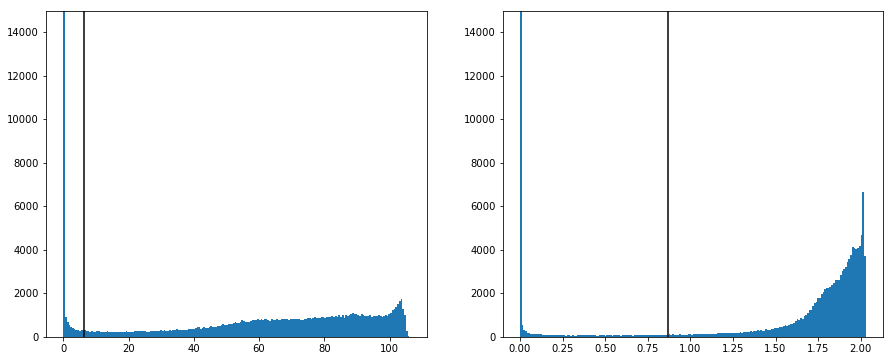

In [32]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
hist(wise[~np.isnan(wise["lr_pc"])]["lr_pc"], bins=200)
vlines([threshold], 0, 15000)
ylim([0,15000])
subplot(1,2,2)
hist(np.log10(wise[~np.isnan(wise["lr_pc"])]["lr_pc"]+1), bins=200)
vlines(np.log10(threshold+1), 0, 15000)
ylim([0,15000]);

## Combine data

First we discard the matches below the threshold

In [33]:
wise["lr_index"] = wise["lr_panstarrs_index"]
wise["lr_index"][wise["lr_pc"] < threshold] = np.nan

We combine the two catalogues using an outer join wich maintains all the data for the two catalogues

In [34]:
panstarrs["lr_index"] = np.arange(len(panstarrs)).astype(float)

In [35]:
combined = join(wise, panstarrs, join_type='outer', keys='lr_index')

## Save catalogue

In [36]:
combined['ra'] = combined['raMean']
combined['dec'] = combined['decMean']
combined['raErr'] = combined['raMeanErr']
combined['decErr'] = combined['decMeanErr']

combined['ra'][np.isnan(combined['raMean'])] = combined['raWise'][np.isnan(combined['raMean'])]
combined['dec'][np.isnan(combined['decMean'])] = combined['decWise'][np.isnan(combined['decMean'])]
combined['raErr'][np.isnan(combined['raMean'])] = combined['raWiseErr'][np.isnan(combined['raMean'])]
combined['decErr'][np.isnan(combined['decMean'])] = combined['decWiseErr'][np.isnan(combined['decMean'])]

Important step to solve problems with the default values for the columns. Check later why we have to do that.

In [37]:
for col in ["raMean", "decMean", "raMeanErr", "decMeanErr",
            "raWise", "decWise", "raWiseErr", "decWiseErr",
            "ra", "dec", "raErr", "decErr"]:
    combined[col].fill_value = 1e+20

In [38]:
columns_save = ['AllWISE', 'objID', 'ra', 'dec', 'raErr', 'decErr', 
                'W1mag', 'W1magErr', 'i', 'iErr']

In [39]:
combined[columns_save].write('pw_bootes.fits', format="fits")

We can also save a version with all the data

In [40]:
np.array(combined.colnames)

array(['AllWISE', 'raWise', 'decWise', 'raWiseErr', 'decWiseErr', 'W1mag',
       'W1magErr', 'lr', 'lr_dist', 'lr_panstarrs_index', 'lr_pc',
       'lr_index', 'objID', 'raMean', 'decMean', 'raMeanErr', 'decMeanErr',
       'i', 'iErr', 'ra', 'dec', 'raErr', 'decErr'], 
      dtype='<U18')

In [41]:
combined.write('pw_bootes_lrdata.fits', format="fits")